# Mandelbrot Fractals with `Gopjrt`

This Go notebook compares drawing mandelbrot fractals generated using pure Go, and using XLA and 2080Ti Nvidia GPU.

Short recap of [Mandelbrot Set](https://en.wikipedia.org/wiki/Mandelbrot_set):
* The generated image is defined over a plane of complex values ($x$ represents the real value, $y$ represents the imaginary value.
* The value at each pixel is the number of iterations ($n$) of the function $z(n+1)=z(n)^2+c$ diverge, where $c$ is the complex number `complex(x,y)`, and we assume that "diverge" is when $|z(n)| > 2$.
* We map the log of the number of iterations to diverge to a corresponding color -- we take the log to decrease the contrast.


## Normal Go Version

Using 24 workers.
	Elapsed: 2.646615ms


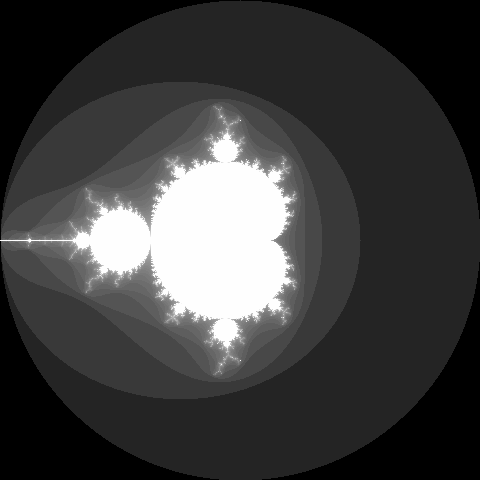

In [7]:

import (
    "github.com/janpfeifer/must"
    "github.com/janpfeifer/gonb/gonbui"
    "github.com/chewxy/math32"
)

func c64Abs(c complex64) float32 {
    return math32.Hypot(real(c), imag(c))
}

func mandelbrot(cx, cy float32, maxIterations int) int {
    c := complex(cx, cy)
    z := complex(float32(0), float32(0))
    for n := 0; n < maxIterations; n++ {
        z = z*z + c
        if c64Abs(z) > 2 {
            return n
        }
    }
    return maxIterations
}

func mandelbrotGo(width, height, maxIterations int, xmin, ymin, xmax, ymax float32) *image.RGBA {
    img := image.NewRGBA(image.Rect(0, 0, width, height))
    logMaxIterations := math32.Log(float32(maxIterations+1))
    rows := make(chan int, height)
    for y := range height {
        rows <- y
    }
    close(rows)

    // Set up worker pool of runtime.NumCPU() to process rows.
    // We assign a whole row as a task because pixel would be to fine-grained.
    fmt.Printf("Using %d workers.\n", runtime.NumCPU())
    var wg sync.WaitGroup
    for _ = range runtime.NumCPU() {
        wg.Add(1)
        go func() {
            for y := range rows {
                cy := ymin + (ymax-ymin)*float32(y)/float32(height)
                for x := 0; x < width; x++ {
                    cx := xmin + (xmax-xmin)*float32(x)/float32(width)
                    iter := mandelbrot(cx, cy, maxIterations)
        
                    // Map iteration count to color
                    colorVal := uint8(255 * math32.Log(float32(iter+1)) / logMaxIterations)
                    img.Set(x, y, color.RGBA{colorVal, colorVal, colorVal, 255})
                }
            }
            wg.Done()
        }()
    }
    wg.Wait()    
    return img
}

%%
start := time.Now()
img := mandelbrotGo(480, 480, 128, -2, -2, 2, 2)
fmt.Printf("\tElapsed: %s\n", time.Since(start))
must.M(gonbui.DisplayImage(img))


## Gopjrt version

Same computation as above, but done in a vectorial fashion.

First we use the `gopjrt` package from the local disk: only needed if the `gopjrt` is cloned locally.

In [2]:
!*rm -f go.work && go work init && go work use . ${HOME}/Projects/gopjrt
%goworkfix
%env LD_LIBRARY_PATH=/usr/local/lib

	- Added replace rule for module "github.com/gomlx/gopjrt" to local directory "/home/janpf/Projects/gopjrt".
Set: LD_LIBRARY_PATH="/usr/local/lib"


We create a container for the PJRT plugin and compiled code. The image size, number of iterations are fixed. But then we can execute it really fast for different areas (xmin, ymin, xmax and ymax).

Compiling XLA program:
	Elapsed: 4.093068988s
Generating image:
	Elapsed: 96.028904ms


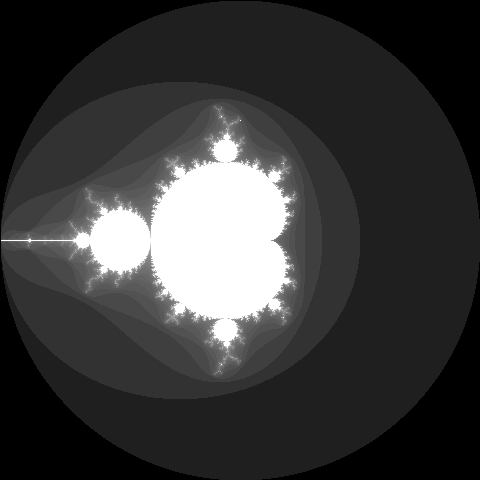

In [5]:
import (
    "flag"
    "time"
    "github.com/gomlx/gopjrt/dtypes"
    "github.com/gomlx/gopjrt/pjrt"
    xla "github.com/gomlx/gopjrt/xlabuilder"
)

var flagPluginName = flag.String("plugin", "cuda", "PRJT plugin name or full path")

type MandelbrotGenerator struct {
    plugin *pjrt.Plugin
    client *pjrt.Client
    width, height, maxIterations int
    exec *pjrt.LoadedExecutable
}

func NewMandelbrotGenerator(width, height, maxIterations int) *MandelbrotGenerator {
    m := &MandelbrotGenerator{
     	plugin: must.M1(pjrt.GetPlugin(*flagPluginName)),
        width: width,
        height: height,
        maxIterations: maxIterations,
    }
    pjrt.SuppressAbseilLoggingHack(func() {
        m.client = must.M1(m.plugin.NewClient(nil))
    })
    m.Build()
    return m
}

func (m *MandelbrotGenerator) Finalize() {
    if m.exec != nil {
        m.exec.Destroy()
        m.exec = nil
    }
    if m.client != nil {
        pjrt.SuppressAbseilLoggingHack(func() {
            m.client.Destroy()
        })
        m.client = nil
    }
    m.plugin = nil
}

// Build the XLA computation that generates the colors (number of iterations to diverge) of the
// Mandelbrot set.
func (m *MandelbrotGenerator) Build() {
    // Create XlaBuilder object and set the dtype and shapes we'll use.
    builder := xla.New("mandelbrot")
    dtype := dtypes.F32
    scalarShape := xla.MakeShape(dtype)
    imageShape := xla.MakeShape(dtype, m.height, m.width)

    // The inputs for the computation are just the (minX, minY) - (maxX, maxY) area we are going to draw.
    // Notice the number of pixels in the image (the size of the matrix we are going to calculate) is
    // fixed -- if we change it we need to re-create the XLA computation.
    minX := must.M1(xla.Parameter(builder, "minX", 0, scalarShape))
    minY := must.M1(xla.Parameter(builder, "minY", 1, scalarShape))
    maxX := must.M1(xla.Parameter(builder, "maxX", 2, scalarShape))
    maxY := must.M1(xla.Parameter(builder, "maxY", 3, scalarShape))

    // Create the matrix (width, height) of complex numbers that are the input for each pixel. 
    // The real (cx) part grows left to right (axis 1), and complex (cy) part grows bottom to top (axis 0).
    cx := must.M1(xla.Iota(builder, imageShape, 1))
    normalizeX := must.M1(xla.Div(
        must.M1(xla.Sub(maxX, minX)),
        must.M1(xla.Constant(builder, xla.NewScalarLiteral(float32(m.width))))))
    cx = must.M1(xla.Mul(cx, normalizeX))
    cx = must.M1(xla.Add(cx, minX))
    cy := must.M1(xla.Iota(builder, imageShape, 0))
    normalizeY := must.M1(xla.Div(
        must.M1(xla.Sub(maxY, minY)),
        must.M1(xla.Constant(builder, xla.NewScalarLiteral(float32(m.height))))))
    cy = must.M1(xla.Mul(cy, normalizeY))
    cy = must.M1(xla.Add(cy, minY))

    // c is the complex number that represents the position of the pixel and the value added to the recursive z function.
    c := must.M1(xla.Complex(cx, cy))

    // z starts with complex64(0) for each pixel.
    zeroC64 := must.M1(xla.ScalarZero(builder, dtypes.C64))
    z := must.M1(xla.Broadcast(zeroC64, imageShape.Dimensions...))

    // Some constants, and we initialize the currentIter.
    zero := must.M1(xla.ScalarZero(builder, dtype))
    one := must.M1(xla.ScalarOne(builder, dtype))
    maxIter := must.M1(xla.Constant(builder, xla.NewScalarLiteral(float32(m.maxIterations))))
    currentIter := zero

    // result start with the maxIter and at each iteration is updated if z reaches the divergence limit.
    // So result can only decrease in value -- at each iteration we take the minimun.
    result := must.M1(xla.Broadcast(maxIter, imageShape.Dimensions...))
    divergeLimit := must.M1(xla.Constant(builder, xla.NewScalarLiteral(float32(2))))

    // Looping over the iterations: notice that while we are looping in Go, the computation graph
    // doesn't have any loops (yet), it's simply generating a giant spaguetti like computation, "loop-unrolling"
    // the whole loop of iterations.
    for _ = range m.maxIterations {
        // Recursive z_{n+1}=z_{n}^2+c
        z = must.M1(xla.Mul(z, z))
        z = must.M1(xla.Add(z, c))

        // Check pixels that diverged.
        diverged := must.M1(xla.GreaterOrEqual(must.M1(xla.Abs(z)), divergeLimit))

        // Update result only for those pixels that diverged.
        resultUpdate := must.M1(xla.Min(result, currentIter))
        result = must.M1(xla.Where(diverged, resultUpdate,result))

        // currentIter++
        currentIter = must.M1(xla.Add(currentIter, one))
    }

    // This finishes the building of the computation, which we then immediately compile and leave it ready to
    // execute.
    computation := must.M1(builder.Build(result))
    builder.Destroy()
    m.exec = must.M1(m.client.Compile().WithComputation(computation).Done())
}

// Exec executes the compiled computation that generates the matrix of values for the Mandelbrot image.
func (m *MandelbrotGenerator) Exec(minX, minY, maxX, maxY float32) *image.RGBA {
    // Create the buffers that PJRT takes to feed the computation.
    inputs := make([]*pjrt.Buffer, 4)
    for ii, value := range []float32{minX, minY, maxX, maxY} {
        inputs[ii] = must.M1(pjrt.ScalarToBuffer(m.client, value))
    }

    // Execute the computation: it has only one output, the resulting the matrix, which we take.
    outputBuffer := must.M1(m.exec.Execute(inputs...).Done())[0]

    // The result is in accelerator memory, this transfers the buffer back to Go-land, in the form
    // of a flat slice, and the dimensions (width x height). Since we know the dimensions, we just
    // discard it here.
    flat, _ := must.M2(pjrt.BufferToArray[float32](outputBuffer))

    // Create the image from the returned matrix, with the number of iterations.
    // Notice we take the `log(#iterations + 1)` as the color to decrease the contrast.
    img := image.NewRGBA(image.Rect(0, 0, m.width, m.height))
    pos := 0
    logMaxIterations := math32.Log(float32(m.maxIterations+1))
    for y := 0; y < m.height; y++ {
        for x := 0; x < m.width; x++ {
            // Map iteration count to color
            colorVal := uint8(255 * math32.Log(flat[pos]+1) / logMaxIterations)
            pos++
            img.Set(x, y, color.RGBA{colorVal, colorVal, colorVal, 255})
        }
    }
    return img
}

%%
fmt.Println("Compiling XLA program:")
start := time.Now()
m := NewMandelbrotGenerator(480, 480, 256)
fmt.Printf("\tElapsed: %s\n", time.Since(start))

fmt.Println("Generating image:")
start = time.Now()
img := m.Exec(-2, -2, 2, 2)
fmt.Printf("\tElapsed: %s\n", time.Since(start))

must.M(gonbui.DisplayImage(img))
m.Finalize()

## Benchmark on large resolution image

We use a reference image of 10000x10000 pixels, with 256 iterations.
    
| **Configuration** | **Go CPU** | **PJRT CPU** | **PJRT GPU** |
|:---:|:---:|:---:|:---:|
| Intel i9-12900K+Nvidia2080Ti GPU | 1.1s | 3.2s | 2.4s |

Duh ... this is a horrible demo for speed gains :) since this algorithm doesn't benefit from vectorial processing: the vectorial version keeps calculating all maxIterations on the whole image, while the normal CPU version stops the processing as soon as things diverge. See next session to observe what happens if we limit the area of the plot to where we need all the itereaions (where most of the area is white).

In [6]:
%test -test.bench=. --plugin=cpu -test.v

const (
    benchmarkWidth = 10000
    benchmarkHeight = 10000
    benchmarkIterations = 256
)

func BenchmarkMandelbrotGo(b *testing.B) {
    _ = mandelbrotGo(benchmarkWidth, benchmarkHeight, benchmarkIterations, -2, -2, 2, 2)
}

func BenchmarkMandelbrotPJRT(b *testing.B) {
    var m *MandelbrotGenerator
    b.Run("compile", func (b *testing.B) {
        if m != nil {
            m.Finalize()
        }
        for i := 0; i < b.N; i++ {
            m = NewMandelbrotGenerator(benchmarkWidth, benchmarkHeight, benchmarkIterations)
        }
    })
    b.Run("exec", func (b *testing.B) {
        for i := 0; i < b.N; i++ {
            _ = m.Exec(-2, -2, 2, 2)     
        }
    })
}

# gonb_3e22db50 [gonb_3e22db50.test] 

 

 Cell[6]: Line 10 
 ./main_test.go:33:9: undefined: mandelbrotGo
 
)

func BenchmarkMandelbrotGo(b *testing.B) {
 _ = mandelbrotGo(benchmarkWidth, benchmarkHeight, benchmarkIterations, -2, -2, 2, 2)
 }

ERROR: failed to run "/home/janpf/src/golang/go/bin/go test -c -o /tmp/gonb_3e22db50/gonb_3e22db50": exit status 1

### Benchmark On Non-Divergent Area

Just for the sake of demonstrating XLA speed gains (in the right scenarios), let's select an area of the fractal where most of the pixels will require MaxIterations 
iterations to be calculated (where everything is white).

So, in the area $-0.5 <= x < 0.5$ and $-0.5 <= y < 0.5$ we get the following timings:

| **Configuration** | **Go CPU** | **PJRT CPU** | **PJRT GPU** |
|:---:|:---:|:---:|:---:|
| Intel i9-12900K+Nvidia2080Ti GPU | 7.2s | 3.2s | 2.4 |


Using 24 workers.


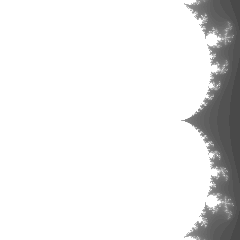

In [8]:
var minX, minY, maxX, maxY float32 = -0.5, -0.5, 0.5, 0.5
%%
must.M(gonbui.DisplayImage(
    mandelbrotGo(240, 240, 256, minX, minY, maxX, maxY)))

In [12]:
var minX, minY, maxX, maxY float32 = -0.5, -0.5, 0.5, 0.5
const (
    benchmarkWidth = 10000
    benchmarkHeight = 10000
    benchmarkIterations = 128
)

%% --plugin=cuda
iters := benchmarkIterations
fmt.Println("Go implementation:")
start := time.Now()
_ = mandelbrotGo(benchmarkWidth, benchmarkHeight, iters, minX, minY, maxX, maxY)
fmt.Printf("\tElapsed: %s\n", time.Since(start))

fmt.Println("Compiling XLA program:")
start = time.Now()
m := NewMandelbrotGenerator(benchmarkWidth, benchmarkHeight, iters)
fmt.Printf("\tElapsed: %s\n", time.Since(start))

fmt.Println("Generating image:")
start = time.Now()
_ = m.Exec(minX, minY, maxX, maxY)
fmt.Printf("\tElapsed: %s\n", time.Since(start))

Go implementation:
Using 24 workers.
	Elapsed: 3.749589181s
Compiling XLA program:
	Elapsed: 3.148206608s
Generating image:
	Elapsed: 2.21864421s
